# Demonstrating the effects of denoising algoritms on text images
## By Oliver Chalkley

I have created a Python library to help with this analysis.

For this document (unless otherwise stated) we will refer to *original*, *noisy*, and *denoised* images. 

The *original* images are images that do not and have never contained noise. Each *original* image has two corresponding *noisy* images (*gaussian noise* and *quasi-crystal noise*) which is the original image plus either Gaussian white noise or quasi-crystal noise. Each *noisy* image has a corresponding *denoised* image for every denoising algorithm attempted.

In [1]:
import algo_test as at # import my library

In [2]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
plt.style.use('seaborn')

First we get all the paths and file names for the images without noise (the original image) and the image with noise (noisy image).

In [3]:
### GET ALL FILENAMES
picture_path = at.get_picture_path() # returns the path to all the images on my VM
denoised_path = '/home/advai-admin-root/projects/ocr_lib/denoised/' # is the path that I wish to save denoised images

all_files = at.get_all_filenames(picture_path) # get all png files in picture_path
all_filenames = [filename.split("/")[-1] for filename in all_files] # remove path from filename

### FILTER FILENAMES
original_filenames_dict = {'b': 0, 'bt': 1, 's': -1, 'dt': -1, 'do': -1, 'string_idx': -1, 'f': -1} # create a dictionary that reprsents all the images with no noise
original_filenames = at.filter_filenames(all_filenames, original_filenames_dict)

gaussian_filenames = []
crystal_filenames = []
for original_fn in original_filenames:
    # get the image properties of this filename
    original_data = at.extract_data_from_filename(original_fn)
    
    # change the image properties from original to gaussian white noise and create corresponding filename
    tmp_gaussian_data = original_data.copy()
    tmp_gaussian_data['bt'] = 0
    gaussian_filenames += [at.create_filename(**tmp_gaussian_data)]
    
    # chnage the image proterties to quasi-crystal noise and create corresponding filename
    tmp_crystal_data = original_data.copy()
    tmp_crystal_data['bt'] = 2
    crystal_filenames += [at.create_filename(**tmp_crystal_data)]

The following gives you an example of an original image with it's corresponding noisy images.

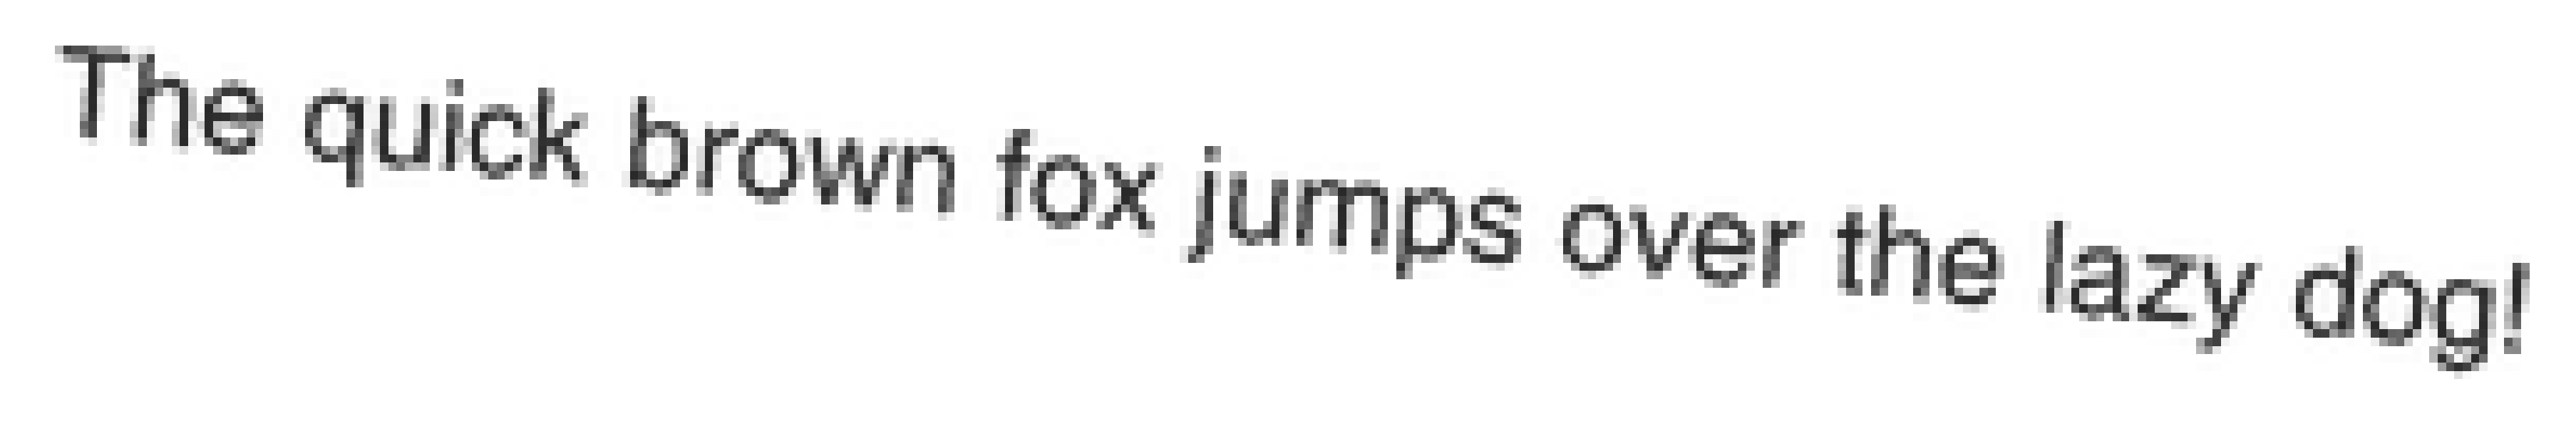

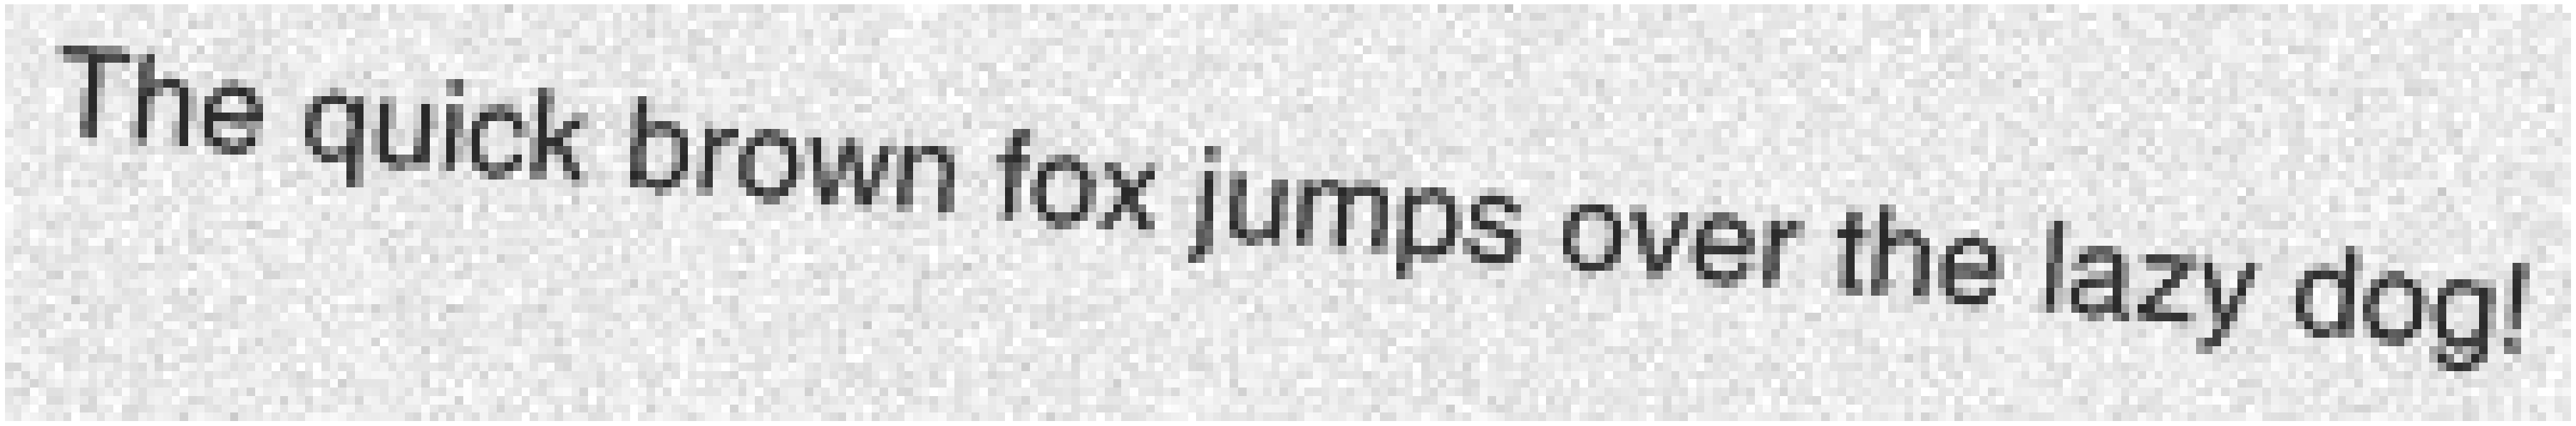

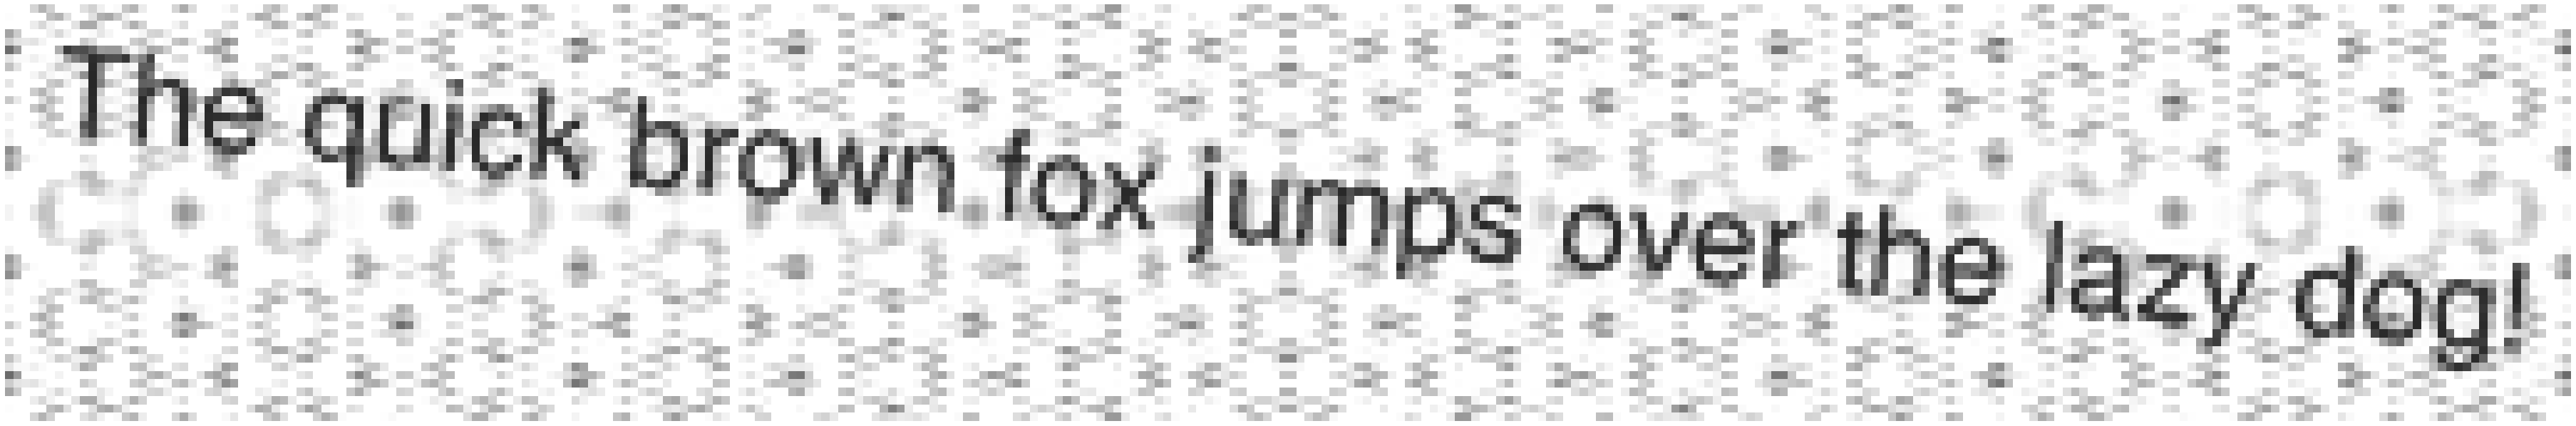

In [4]:
demo_idx = 0
demo_fullpath_o = picture_path + original_filenames[demo_idx]
demo_fullpath_g = picture_path + gaussian_filenames[demo_idx]
demo_fullpath_c = picture_path + crystal_filenames[demo_idx]
at.display_file(demo_fullpath_o)
at.display_file(demo_fullpath_g)
at.display_file(demo_fullpath_c);

In the next section we will manually inspect the affects of the denoising algorithms.

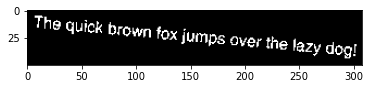

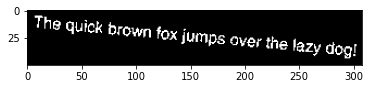

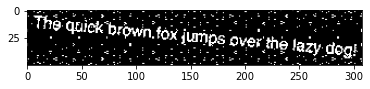

In [5]:
# load, greyscale and binarise the images and re-view them
img_o = at.callum_binarise(demo_fullpath_o)
img_g = at.callum_binarise(demo_fullpath_g)
img_c = at.callum_binarise(demo_fullpath_c)
at.display_image(img_o)
at.display_image(img_g)
at.display_image(img_c);

# now we invert img_c
#img_c = cv2.bitwise_not(img_c)
#at.display_image(img_c);

We can see here that the callcums binarisation method has actually completely denoised the Gaussian white noise and whilst the quasi-crystal noise is still present it looks far more managable now since it is in clumps rather than complex patterns. It is also worth noting that the text has been affected quite significantly in a negative way.

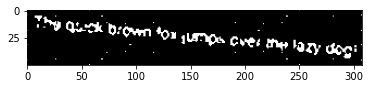

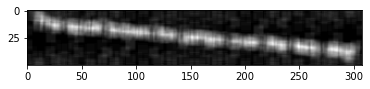

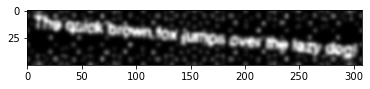

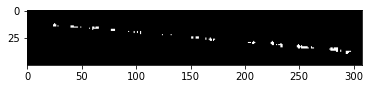

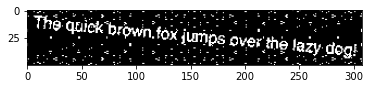

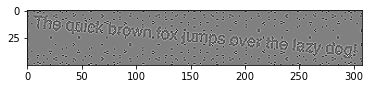

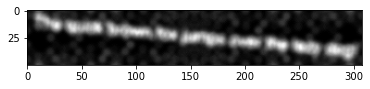

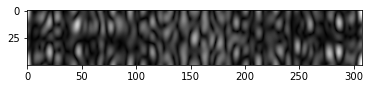

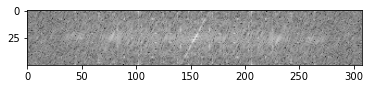

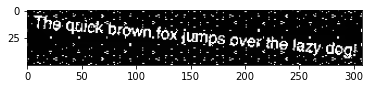

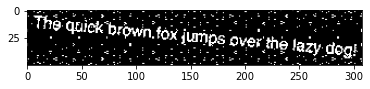

In [6]:
# get all the denoising functions
kernal_size = 9
sigma_x, sigma_y = 0, 0
radius, percent = 2, 150

nr = at.noise_removal(img_c)
meanf = at.mean_filter(img_c, kernal_size)
gaussf = at.gaussian_filter(img_c, kernal_size, sigma_x, sigma_y)
medianf = at.median_filter(img_c, kernal_size)
conservativef = at.conservative_filter(img_c, kernal_size)
laplacianf = at.laplacian_filter(img_c)
logf = at.laplacian_of_gaussian_filtering(img_c, kernal_size, sigma_x, sigma_y)
lp_dft_f = at.low_pass_dft(img_c)
freq_spectrum = lp_dft_f[1]
lp_dft_f = lp_dft_f[0]
crimminsf = at.crimmins_speckle_removal(img_c)
unsharpf = np.array(at.unsharp_filter(img_c, radius=radius, percent=percent))

at.display_image(nr)
at.display_image(meanf)
at.display_image(gaussf)
at.display_image(medianf)
at.display_image(conservativef)
at.display_image(laplacianf)
at.display_image(logf)
at.display_image(lp_dft_f)
at.display_image(freq_spectrum)
at.display_image(crimminsf)
at.display_image(unsharpf);

We can see that all denoising algorithms performed very badly. An investogation needs to be done into how we can improve this. However, first we will look at the metrics I created to measure the success of algorithms and then once this is established then we can look at optimising algorithm performance with the use of quantitative metrics.

In [7]:
results = at.get_error_breakdown(img_o, img_c, at.noise_removal, {})

We will now look at and try to understand the metrics contained in `get_error_break_down`.

## Total denoising error

The first metric is the *total denoising error* which can be thought of as what the denoising algorithm got wrong. This is calculated by taking the denoised image away from the original image which gives us all the wrong pixels returned from the denoising algorithm (it should be intuitive that if the denoising algorithm is perfect then the total denoising error will be blank). This can be made up of two types of errors. The first is noise that remains in the image after denoising and the second is pixels that have been added or subtracted to the letters.

Original image: 


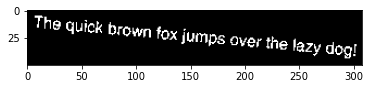

Denoised noisy image:  (1229.0, 0.07980519480519481)


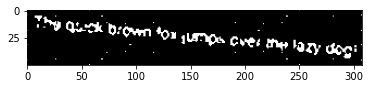

Total denoised error:  (518.0, 0.03363636363636364)


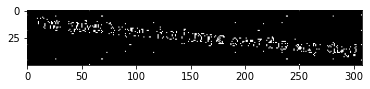

Percentage of wrong pixels in the denoised image is  42.148087876322215 %.


In [8]:
# TOTAL NOISE
print('Original image: ')
at.display_image(img_o)
dni_stats = at.get_error(results['total'][2])
print('Denoised noisy image: ', dni_stats)
at.display_image(results['total'][2])
print('Total denoised error: ', results['total'][1])
at.display_image(results['total'][0]);
print('Percentage of wrong pixels in the denoised image is ', results['total'][1][0] / dni_stats[0] * 100, '%.')

We can see from the denoised noisy image that some of the noise is missed and the text has also become less readable. The total denoised error illustrates exactly what that difference is and it is striking just how much the text has been changed by the algorithm. It also tells us that there are 518 pixels different between the original image and the denoised image which represents about 3% of all the pixels in the image. It is salso shown that about 42% of the pixels in the denoised image are wrong. It looks like most of the wrong pixels are around the letters rather than in the random noise around the text but can we quantify that?

## Pure noise error

The *pure noise error* looks at how well the denoising algorithm performs on just noise. It is calculated by subtracting the original image from the noisy image. This removes the text from the noisy image leaving just pure noise. The denoising algorithm is then run on the pure noise.

Noisy image: 


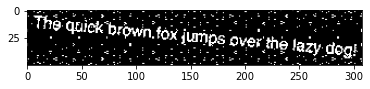

Pure noise:  (722.0, 0.04688311688311688)


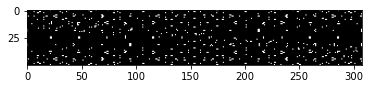

Pure noise denoised:  (44.0, 0.002857142857142857)


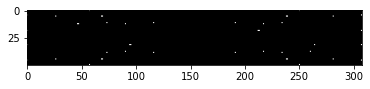

The denoising algorithm removed  93.90581717451524 % of the pure noise which resulted in about  0.2857142857142857 % of the whole image containing wrong pixels.


In [15]:
# PURE NOISE
print('Noisy image: ')
at.display_image(img_c)
print('Pure noise: ', results['pure'][1])
at.display_image(results['pure'][0])
print('Pure noise denoised: ', results['pure'][3])
at.display_image(results['pure'][2]);
print('The denoising algorithm removed ', (1 - results['pure'][3][0] / results['pure'][1][0]) * 100, '% of the pure noise which resulted in about ', results['pure'][3][1] * 100, '% of the whole image containing wrong pixels.')

The pure noise image above shows us what the noisy image looks like when you remove the text and it is clear that there is some noise overlapping with the text. The pure noise denoised image shows that the denoising algorithm has removed a lot of the pure noise. From the statistics we can see that there is 722 pixels of pure noise or 5% of the entire image. There are 44 noise pixels left after denoising which is 0.3% of the entire image. The 44 remaining noise pixels represents a 94% reduction of pure noise leaving only 6% of the pure noise behind.  

## The letter to noise effect

In the last section we saw how the algorithm performed on pure noise. This then raises the question of how the algorithm affects the letters and conversely how the letters affect the algorithm results. We will first look at the latter which we call the *letter to denoising algorithm effect*.

The algorithm takes the *total denoised error* and subtracts the *pure denoised error*. This leaves us with the denoising error that can't be explained by the pure denoising error. This can also be thought of as the denoising error caused by the letters.

Total noisy denoised error:  (518.0, 0.03363636363636364)


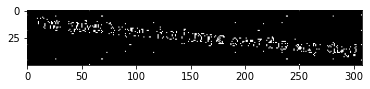

Pure noise denoised: (44.0, 0.002857142857142857)


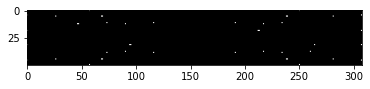

The denoising error that can't be accounted for by pure noise denoising error (ie the affect of the letters on the denoising algorithm - letters to noise affect):  (478.0, 0.03103896103896104)


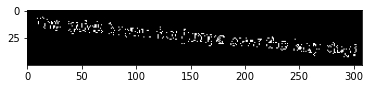

Of the wrong pixels in the total denoised error  92.27799227799228 % can be attributed to the letter to noise affect.


In [10]:
# Letter to noise effect 
total_stats = at.get_error(results['total'][0])
print('Total noisy denoised error: ', total_stats)
at.display_image(results['total'][0])
print('Pure noise denoised:', results['pure'][3])
at.display_image(results['pure'][2])
print("The denoising error that can't be accounted for by pure noise denoising error (ie the affect of the letters on the denoising algorithm - letters to noise affect): ", results['ltu'][3])
at.display_image(results['ltu'][2]);
print('Of the wrong pixels in the total denoised error ', results['ltu'][3][0] / total_stats[0] * 100, '% can be attributed to the letter to noise affect.')

We can see that that there is a significant amount of pixels left but it is hard to see how much of it is remaining letters and how much is remaining noise (especiailly since the algorithm has changed the lettering so much). The letter to noise affect image shows that the noise around the outside is removed and we now onlt have errors around the text which is what we would expect. The letter to noise affect shows 478 wrong pixels or 3% of the total image. Of the 518 wrong pixels in the denoised image, 93% of them can be attributed to the letter to noise affect and 7% to incorrectly denoising the pure noise.

## Noise to letter affect

This metric looks at how the denoising algorithm affects the letters. This is calculated by subtracted the original letters away from the denoising error created by text (ie the letter to noise affect). This leaves us with how the letters are affected by the algorithm.

The denoising error created by text (ie letter to noise):  (478.0, 0.03103896103896104)


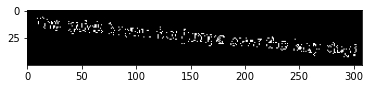

Original image: 


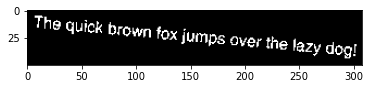

Noise to letter affect (ie how the letters are affected by the denoising algorithm): (1185.0, 0.07694805194805195)


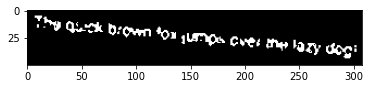

The denoised image is: 


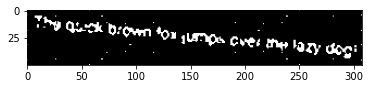

Of the pixels in the denoised image  96.41985353946298 % is the letters.


In [14]:
# Noise to letter affect
print('The denoising error created by text (ie letter to noise): ', results['ltu'][3])
at.display_image(results['ltu'][2]);
print('Original image: ')
at.display_image(img_o)
print('Noise to letter affect (ie how the letters are affected by the denoising algorithm):', results['ltu'][1])
at.display_image(results['ltu'][0])
print('The denoised image is: ')
at.display_image(results['total'][2])
denoised_stats = at.get_error(results['total'][2])
print('Of the pixels in the denoised image ', results['ltu'][1][0] / denoised_stats[0] * 100, '% is the letters.')


The noise to letter affect image shows just the remaining text after denoising but wothout the remaining noise. It can be seen that the denoising algorithm affects the letters enough to make the letters almost unreadable. The remaining text represents 8% of the total image. 96% of the white pixels in total denoised image. Although it is worth remembering that the amount the letters have changed from the original letters is very significant.

## Abstract representation

### Total noise error
$$total\_noise\_error = denoised\_noise - original\_image = \Delta \left(noisy\_image \right) - original\_image $$
### Pure noise:
$$pure\_noise = noisy\_image - original\_image$$
### Pure denoised error:
$$pure\_denoised\_error = denoised\_pure\_noise = \Delta \left( pure\_noise \right)$$
### Letter to noise affect:
$$letter\_to\_noise\_affect = total\_denoised\_error - pure\_denoised\_error$$
### Noise to letter affect:
$$noise\_to\_letter = letter\_to\_noise - original$$

Thus given the original image ($I^O$), the original image with noise added ($I^N$) and an arbitrary denoising algorithm ($\Delta$) we can expand the above to:

**Total noise error:**
$$ \Delta \left( I^N \right) - I^O $$

**Pure noise:**
$$I^N - I^O$$

**Pure noise error:**
$$\Delta \left( I^N - I^O \right)$$

**Letter to noise affect:**
$$\left( \Delta \left( I^N \right) - I^O \right) - \Delta \left( I^N - I^O \right)$$

**Noise to letter affect:**
$$\left( \left( \Delta \left( I^N \right) - I^O \right) - \Delta \left( I^N - I^O \right) \right) - I^O$$

## Conclusions

We would like to find a metric to represent how well a denoising algorithm performed.

Intuitively one can look at how similar the denoised image is from the original image. However there are two different ways that errors can be formed. The first is the denoising missing bits of noise. The second is from changing the pixels around text. This can be done in many different ways depending on how you define the difference between two images. This document looks at the absolute difference of pixels between the two images.

We find 4 metics that may be useful in defining the similarity using the absolute difference of pixels.
 - The difference between the original image and the denoised noisy image, which we call the *total denoised error*.
 - The remainign noise after denoising the pure noise, which we call the *pure denoised error*.
 - The difference between the *total denoised error* and the *pure denoised error*, which we call the *letter to noise affect* i.e. the affcet that the letters have on the denoising algorithm.
     - Can also be thought of as the denoising error that can't be exampled by denoising pure denoise.
 - The difference between the *letter to noise affect* and the original image which we call the noise to letter affect i.e. the affect that the denoising algorithm has on the letters.
     - Can also be thought of as the affect on the letters without the pure noise error.
     
*Total denoised error* represents the overall effectiveness of the denoising algorithm but we pointed out that errors can form in two different ways (missing noise and changing the text). Denosing the pure noise shows us the first type of error. The letter to noise affect shows us the second type of error. 

We propose that a denoising algorithm be represented by a 3-deminsional point. The first dimension respresents the overall error (i.e. total denoised error) which we use the proportion of the denoised image that is made up of wrong pixels. The second dimension represents the first type of error (i.e. how effectively the algorithm removes noise) which we use the proportion of the total denoised error that is missed random noise. The third dimension represents the second type of error (i.e. the letter to noise affect) which we use the proportion of the total denoised error that is related to letter changes. It's worth noting that the total denoising error is a function of the first and second types of error.

This methodology requires that the denoising algorithm is completely deterministic and so will not work on denoising functions that do not form a one to one mapping between the inputs and outputs. We have used the concept of difference in pixels to measure difference between images. However, difference in pixels doesn't neccessarily directly translate to information. Above is a good example of this as we can see that the letters have been changed a lot between the original image and the denoised noisy image (see the letter to noise affect). Despite maany pixels being diffferent you can still just about read the text. This is because the denoising algorithm has *smeared* the letter pixels meaning that most of the pixels are in different places but it still holds a lot of the shape of the original letters. One potential way to look at how well the information is contained in it is by using OCR to convert into text and see how well it does. The problem with this is that the image needs to be rotated etc first.

We shoul consider using standardisation rather than percentages because an algorithm could remove a lot of noise which proportionally is not that big and conversely an algorithm might only remove a small amount of noise but because there wasn't that much in the first place it gives a high percentage.

In [1]:
import multiprocessing as mp

In [2]:
mp.cpu_count()

12